In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import emoji
from collections import Counter

In [15]:
def rawToDf(file, key):
    split_formats = {
        '12hr' : '\d{1,2}/\d{1,2}/\d{2,4},\s\d{1,2}:\d{2}\s[APap][mM]\s-\s',
        '24hr' : '\d{1,2}/\d{1,2}/\d{2,4},\s\d{1,2}:\d{2}\s-\s',
        'custom' : ''
    }
    datetime_formats = {
        '12hr' : '%d/%m/%Y, %I:%M %p - ',
        '24hr' : '%d/%m/%Y, %H:%M - ',
        'custom': ''
    }
    
    with open(file, 'r',encoding="utf8") as raw_data:
        raw_string = ' '.join(raw_data.read().split('\n')) # converting the list split by newline char. as one whole string as there can be multi-line messages
        user_msg = re.split(split_formats[key], raw_string) [1:] # splits at all the date-time pattern, resulting in list of all the messages with user names
        date_time = re.findall(split_formats[key], raw_string) # finds all the date-time patterns
        
        df = pd.DataFrame({'date_time': date_time, 'user_msg': user_msg}) # exporting it to a df
        
    # converting date-time pattern which is of type String to type datetime,
    # format is to be specified for the whole string where the placeholders are extracted by the method 
    df['date_time'] = pd.to_datetime(df['date_time'], format=datetime_formats[key])
    
    # split user and msg 
    usernames = []
    msgs = []
    for i in df['user_msg']:
        a = re.split('([\w\W]+?):\s', i) # lazy pattern match to first {user_name}: pattern and spliting it aka each msg from a user
        if(a[1:]): # user typed messages
            usernames.append(a[1])
            msgs.append(a[2])
        else: # other notifications in the group(eg: someone was added, some left ...)
            usernames.append("grp_notif")
            msgs.append(a[0])

    # creating new columns         
    df['user'] = usernames
    df['msg'] = msgs

    # dropping the old user_msg col.
    df.drop('user_msg', axis=1, inplace=True)
    
    return df

In [24]:
df = rawToDf('..\Downloads\Telegram Desktop\WhatsApp Chat with Chakraborty Debo3.txt','12hr')

In [25]:
df.tail()

,date_time,user,msg
39994,2020-06-30 00:30:00,Shiva,Fr ur smile
39995,2020-06-30 00:30:00,Shiva,On
39996,2020-06-30 00:30:00,Chakraborty Debo3,😄😄😄😄😄
39997,2020-06-30 00:30:00,Chakraborty Debo3,😁
39998,2020-06-30 00:30:00,Shiva,K 👋🏼


In [26]:
df.shape

(39999, 3)

In [27]:
me = 'Shiva'

In [28]:
images = df[df['msg']=="<Media omitted> "]
images.shape

(1979, 3)

In [29]:
df.drop(images.index, inplace=True)

In [30]:
df.reset_index(inplace=True,drop=True)
df.tail()

,date_time,user,msg
38015,2020-06-30 00:30:00,Shiva,Fr ur smile
38016,2020-06-30 00:30:00,Shiva,On
38017,2020-06-30 00:30:00,Chakraborty Debo3,😄😄😄😄😄
38018,2020-06-30 00:30:00,Chakraborty Debo3,😁
38019,2020-06-30 00:30:00,Shiva,K 👋🏼


In [31]:
df.groupby('user')['msg'].count().sort_values(ascending = False)

user
Shiva                21623
Chakraborty Debo3    16397
Name: msg, dtype: int64

In [34]:
emoji_ctr = Counter()
emojis_list = map(lambda x: ''.join(x.split()), emoji.UNICODE_EMOJI.keys())
r = re.compile('|'.join(re.escape(p) for p in emojis_list))
for idx, row in df.iterrows():
    if row["user"] == me:
        emojis_found = r.findall(row["msg"])
        for emoji_found in emojis_found:
            emoji_ctr[emoji_found] += 1

In [38]:
for item in emoji_ctr.most_common(10):
    print(item[0] + " - " + str(item[1]))

🤣 - 1667
😘 - 798
🌚 - 393
🏼 - 381
😅 - 337
🥺 - 327
🤗 - 244
😛 - 230
🤦🏼‍♂️ - 208
🏻 - 200


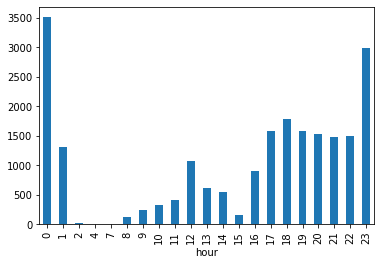

In [39]:
df['hour'] = df['date_time'].apply(lambda x: x.hour)
df[df['user']==me].groupby(['hour']).size().sort_index().plot(x="hour", kind='bar')

In [40]:
df['weekday'] = df['date_time'].apply(lambda x: x.day_name())

In [41]:
df['is_weekend'] = df.weekday.isin(['Sunday', 'Saturday'])
df.tail()

,date_time,user,msg,hour,weekday,is_weekend
38015,2020-06-30 00:30:00,Shiva,Fr ur smile,0,Tuesday,False
38016,2020-06-30 00:30:00,Shiva,On,0,Tuesday,False
38017,2020-06-30 00:30:00,Chakraborty Debo3,😄😄😄😄😄,0,Tuesday,False
38018,2020-06-30 00:30:00,Chakraborty Debo3,😁,0,Tuesday,False
38019,2020-06-30 00:30:00,Shiva,K 👋🏼,0,Tuesday,False


In [42]:
df.groupby('is_weekend').count()

,date_time,user,msg,hour,weekday
is_weekend,,,,,
False,26944,26944,26944,26944,26944
True,11076,11076,11076,11076,11076


In [43]:
x = df.groupby(['hour', 'weekday'])['msg'].size().reset_index()
x2 = x.pivot("hour", 'weekday', 'msg')
x2.head()

weekday,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
hour,,,,,,,
0,923.0,787.0,873.0,863.0,720.0,711.0,972.0
1,566.0,220.0,283.0,293.0,309.0,301.0,210.0
2,8.0,NaN,1.0,19.0,1.0,2.0,NaN
4,NaN,NaN,1.0,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,4.0,4.0,3.0,NaN


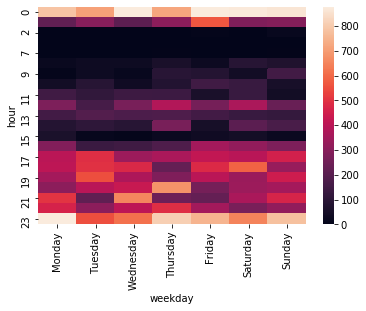

In [44]:
days = ["Monday", 'Tuesday', "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
sns.heatmap(x2[days].fillna(0), robust=1)

In [45]:
comment_words = ' '
stopwords = STOPWORDS.update(['lo', 'ge', 'Lo', 'illa','se','ka','may','ke', 'yea', 'ella', 'en', 'na', 'En', 'yeah', 'alli', 'ide', 'okay', 'ok', 'will'])
  
for val in df.msg.values: 
    val = str(val) 
    tokens = val.split() 
        
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '
  
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 

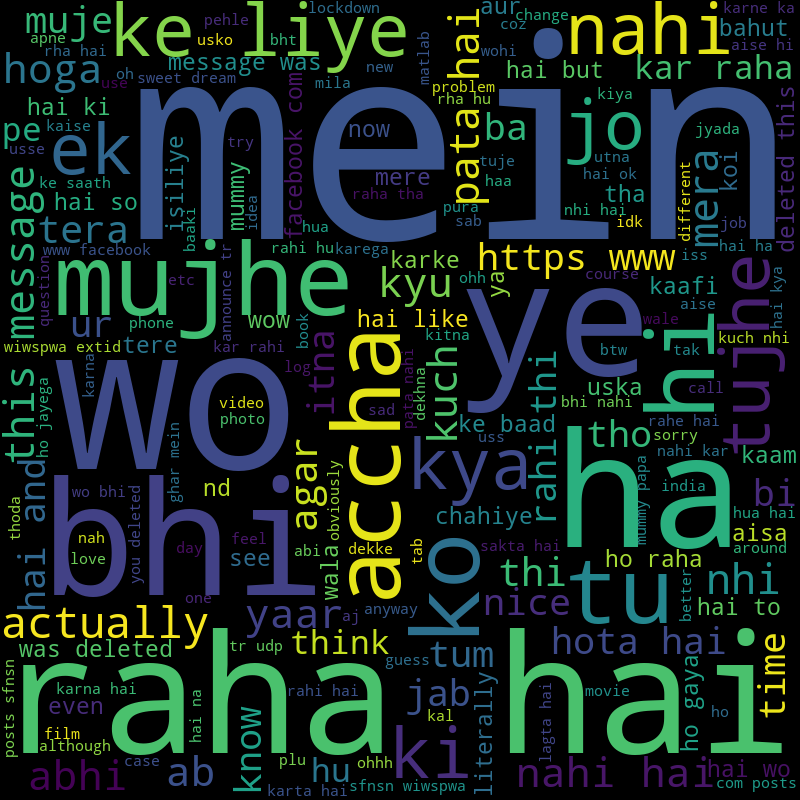

In [46]:
wordcloud.to_image()